In [4]:
# import preprocess as prep
import SLR_model
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
import os
import json
import importlib
from matplotlib import pyplot as plt
import preprocess

# model will output multiple(15) results/sec, how are we gonna handle it?

In [16]:
 # reload model file
importlib.reload(SLR_model)
importlib.reload(preprocess)

<module 'preprocess' from 'C:\\Users\\shd\\Documents\\capstone\\BomNae-SLR\\preprocess.py'>

In [6]:
# utility functions

def bin2num(bin_arr):
    # big endian
    # lower index > higher exponent
    num = 0
    for val in bin_arr:
        num = (num << 1) | val
    return num

# def num2bin(num, arr_len = -1):
#     # big endian
#     # lower index > higher exponent
#     bin_arr = [int(x) for x in bin(num)[2:]]
#     diff = arr_len - len(bin_arr)
#     if diff < 1:
#         return bin_arr
#     else:
#         pad = [0] * diff
#         return pad+bin_arr
    
def num_arr2bin(num_arr, out_len = -1):
    # big endian
    # lower index > higher exponent
    res = []
    for num in num_arr:
        str_list = list(np.binary_repr(num).zfill(out_len))
        bin_arr = np.array(str_list, dtype=np.float32)
        res.append(bin_arr)
    return np.array(res)

def serialize(vids, stride = 1):
    """input shape: (load_size, frames)\n
    ouput shape: (load_size, input_seq_size, 63 or 32, frames)"""
    each_size = []
    x_res = []
    for vid in vids:
        window_len = 0
        start = 0
        while (start + 63) < len(vid):
            x_res.append(vid[start: start+63: stride])
            window_len += 1
            start += 6
        each_size.append(window_len)
    return np.array(x_res), each_size

In [7]:
# Configurations
load_size = 256 # number of data to be loaded at once
epochs = 10
batch_size = 16
save_dir = "saves"
load_dir = "saves"
# load_path = "C:/Users/jerry/Desktop/hly/2024-2/cap/BN_SLR/BomNae-SLR/checkpoints.keras"


In [19]:
# # dummy x_raw data
# l_raw = []
# duration_list = []
# for i in range(load_size):
#     h_elem = np.zeros(shape=(4,5,3))
#     # p_elem = np.zeros(shape=(3,10))
#     # comb_elem = [h_elem, h_elem, p_elem]
#     x_elem = []
#     duration = (np.random.randint(70,91))
#     duration_list.append(duration)
#     for j in range(duration): # frame size
#         x_elem.append(h_elem)
#         # x_elem.append(comb_elem)
#     l_raw.append(x_elem)
# r_raw = []
# for i in range(load_size):
#     h_elem = np.zeros(shape=(4,5,3))
#     # p_elem = np.zeros(shape=(3,10))
#     # comb_elem = [h_elem, h_elem, p_elem]
#     x_elem = []
#     duration = duration_list[i]
#     for j in range(duration): # frame size
#         x_elem.append(h_elem)
#         # x_elem.append(comb_elem)
#     r_raw.append(x_elem)
# p_raw = []
# for i in range(load_size):
#     # h_elem = np.zeros(shape=(4,5,3))
#     p_elem = np.zeros(shape=(3,10))
#     # comb_elem = [h_elem, h_elem, p_elem]
#     x_elem = []
#     duration = duration_list[i]
#     for j in range(duration): # frame size
#         # x_elem.append(h_elem)
#         x_elem.append(p_elem)
#         # x_elem.append(comb_elem)
#     p_raw.append(x_elem)

# # dummy y_raw data
# # y_raw = np.random.randint(0,1024,load_size)
# y_raw = np.zeros(shape=(load_size,), dtype=np.int32)

In [12]:
l_raw, r_raw, p_raw, y_raw ,check_raw= preprocess.load_word(1,1,load_size)

In [21]:
l_train, each = serialize(l_raw)
r_train, each = serialize(r_raw)
p_train, each = serialize(p_raw, stride=2)
y_train = np.repeat(y_raw, each)
y_train = num_arr2bin(y_train, 12)

In [14]:
print(check_raw)

[array(['1', '고민'], dtype='<U11'), array(['1', '뻔뻔'], dtype='<U11'), array(['1', '수어'], dtype='<U11'), array(['1', '남아'], dtype='<U11'), array(['1', '눈'], dtype='<U11'), array(['1', '독신'], dtype='<U11'), array(['1', '음료수'], dtype='<U11'), array(['1', '발가락'], dtype='<U11'), array(['1', '슬프다'], dtype='<U11'), array(['1', '자극'], dtype='<U11'), array(['1', '안타깝다'], dtype='<U11'), array(['1', '어색하다'], dtype='<U11'), array(['1', '여아'], dtype='<U11'), array(['1', '외국인'], dtype='<U11'), array(['1', '영아'], dtype='<U11'), array(['1', '신사'], dtype='<U11'), array(['1', '뉴질랜드'], dtype='<U11'), array(['1', '나사렛대학교'], dtype='<U11'), array(['1', '알아서'], dtype='<U11'), array(['1', '장애인'], dtype='<U11'), array(['1', '열아홉번째'], dtype='<U11'), array(['1', '침착'], dtype='<U11'), array(['1', '성실'], dtype='<U11'), array(['1', '학교연혁'], dtype='<U11'), array(['1', '싫어하다'], dtype='<U11'), array(['1', '급하다'], dtype='<U11'), array(['1', '필기시험'], dtype='<U11'), array(['1', '병문안'], dtype='<U11'), array(['1', '검사'], dt

In [22]:
# hand input shape: (batch, time, h, w, channels)
# pose input shape: (batch, time, channel, features)

In [23]:
x_train = (l_train, r_train, p_train)

In [24]:
model = SLR_model.get_model()

In [25]:
# # 세이브된 모델 로드
# load_path = os.join(load_dir, "check_00-00-00.keras")
# model = SLR_model.load_model(load_path)

In [26]:
# # 안될때 (강제중지 + 초기화)
# tf.keras.backend.clear_session()

In [27]:
# hist = model.fit(x_train, y_train, epochs=epochs, batch_size= batch_size, callbacks=[model_checkpoint_callback])

In [28]:
dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size)

In [29]:
save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))
check_path = os.path.join(save_dir, "check"+save_suffix)
hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=f'{check_path}.keras',
    monitor='binary_accuracy',
    mode='max',
    save_freq='epoch',
    save_best_only=True)

hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])

with open(hist_path, 'w') as file:
    json.dump(hist.history, file)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.5615 - loss: 0.6761
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6144 - loss: 0.5520
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6273 - loss: 0.5205
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6332 - loss: 0.5085
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6372 - loss: 0.5016
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6393 - loss: 0.4967
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6419 - loss: 0.4928
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6447 - loss: 0.4895
Epoch 9/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6485 - loss: 0.4866
Epoch 10/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6527 - loss: 0.4841


In [26]:
 # reload model file
importlib.reload(SLR_model)
importlib.reload(preprocess)
end_file=preprocess.getoutputdir()

for i in range(1,17):
    load_size_j=load_size
    l_raws=[]
    r_raws=[]
    p_raws=[]
    y_raws=[]
    count=0
    print(i)
    for j in os.listdir(os.path.join(preprocess.getoutputdir(),str(i))):
        print(j)
        l_raw, r_raw, p_raw, y_raw = preprocess.load_data(f"{i}/{j}")
        
        l_raws.append(l_raw)
        r_raws.append(r_raw)
        p_raws.append(p_raw)
        y_raws.append(y_raw)
        
        if count>=load_size:
            l_train, each = serialize(l_raw)
            r_train, each = serialize(r_raw)
            p_train, each = serialize(p_raw, stride=2)
            y_train = np.repeat(y_raw, each)
            y_train = num_arr2bin(y_train, 12)
            x_train = (l_train, r_train, p_train)
        
            dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size)
        
            save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))
            check_path = os.path.join(save_dir, "check"+save_suffix)
            hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")
        
            model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
                filepath=f'{check_path}.keras',
                monitor='binary_accuracy',
                mode='max',
                save_freq='epoch',
                save_best_only=True)
        
            hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
            
            with open(hist_path, 'w') as file:
                json.dump(hist.history, file)
            count=0
            l_raws.clear()
            r_raws.clear()
            p_raws.clear()
            y_raws.clear()
        else:
            count+=1
    if len(l_raws)>0:
        l_train, each = serialize(l_raw)
        r_train, each = serialize(r_raw)
        p_train, each = serialize(p_raw, stride=2)
        y_train = np.repeat(y_raw, each)
        y_train = num_arr2bin(y_train, 12)
        x_train = (l_train, r_train, p_train)
    
        dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size)
    
        save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))
        check_path = os.path.join(save_dir, "check"+save_suffix)
        hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")
    
        model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
            filepath=f'{check_path}.keras',
            monitor='binary_accuracy',
            mode='max',
            save_freq='epoch',
            save_best_only=True)
    
        hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
        
        with open(hist_path, 'w') as file:
            json.dump(hist.history, file)
        


    

1
1.npz
고민
10.npz
자극
100.npz
사이다
1000.npz
속다
1001.npz
한국농아인협회
1002.npz
한국농아인협회
1003.npz
서울특별시농아인협회
1004.npz
서울특별시수어통역센터
1005.npz
서울시청
1006.npz
강남구지부
1007.npz
강남구수어통역센터
1008.npz
강동구지부
1009.npz
강동구수어통역센터
101.npz
달다
1010.npz
강동구주민지원센터
1011.npz
강북구지부
1012.npz
강북구수어통역센터
1013.npz
강북구주민지원센터
1014.npz
강서구지부
1015.npz
강서구수어통역센터
1016.npz
강서구주민지원센터
1017.npz
관악구지부
1018.npz
관악구수어통역센터
1019.npz
관악구주민지원센터
102.npz
소주
1020.npz
광진구지부
1021.npz
광진구수어통역센터
1022.npz
광진구주민지원센터
1023.npz
구로구지부
1024.npz
구로구수어통역센터
1025.npz
구로구주민지원센터
1026.npz
금천구지부
1027.npz
금천구수어통역센터
1028.npz
노원구지부
1029.npz
노원구수어통역센터
103.npz
술잔
1030.npz
노원구주민지원센터
1031.npz
도봉구지부
1032.npz
도봉구수어통역센터
1033.npz
도봉구주민지원센터
1034.npz
동대문구지부
1035.npz
동대문구수어통역센터
1036.npz
동대문구주민지원센터
1037.npz
동작구지부
1038.npz
동작구수어통역센터
1039.npz
동작구주민지원센터
104.npz
식당
1040.npz
마포구지부
1041.npz
마포구수어통역센터
1042.npz
마포구주민지원센터
1043.npz
서대문구지부
1044.npz
서대문구수어통역센터
1045.npz
서대문구주민지원센터
1046.npz
서초구지부
1047.npz
서초구수어통역센터
1048.npz
서초구주민지원센터
1049.npz
성동구지부
105.npz
쌀가루
1050.npz
성동구수어통역센터
1051.npz
성동구주

ValueError: operands could not be broadcast together with shape (1,) (142,)

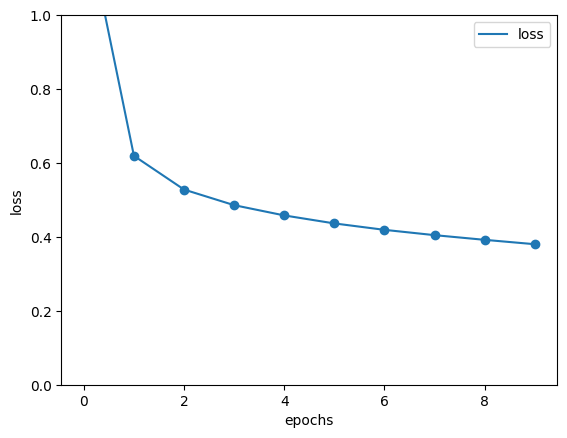

In [53]:
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.scatter(range(len(hist.history['loss'])), hist.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["loss"])
plt.ylim((0,1))
plt.show()

In [84]:
# importlib.reload(SLR_model)
# model = SLR_model.get_model()

In [85]:
# pred = model.predict(x_dummy, batch_size=1)

In [12]:
eval_res = model.evaluate(x_train, y_train, batch_size= batch_size)

ValueError: Exception encountered when calling HandModel.call().

[1mas_list() is not defined on an unknown TensorShape.[0m

Arguments received by HandModel.call():
  • x=tf.Tensor(shape=(None, 63, 4, 5, 3), dtype=float32)
  • training=False

In [13]:
print(eval_res)

NameError: name 'eval_res' is not defined

In [14]:
model.metrics_names

['loss', 'compile_metrics']